In [1]:
!pip install split-folders

In [2]:
import math
import os
import numpy as np

# PYTORCH
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import splitfolders

# TORCHMETRICS & TORCHVISION
import torchmetrics
from torchvision import datasets, transforms, models
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandAugment
from torchsummary import summary

# TRANSFORMERS LIBRARY FOR PRETRAINED VIT
from transformers import ViTForImageClassification, ViTConfig, ViTFeatureExtractor

# LIGHTNING MODULE
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, RichProgressBar, ModelCheckpoint, EarlyStopping

# PLOTTING & LOGGING
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-04-22 10:10:39.012062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745316639.334911      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745316639.407705      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
KAGGLE_INPUT_DIR = '/kaggle/input/forest/RawFireData'
KAGGLE_WORKING_DIR = '/kaggle/working/FireData'

In [5]:
torch.manual_seed(42)
np.random.seed(42)

In [6]:
batch_size = 32
img_height = 224
img_width = 224
learning_rate = 2e-4
epochs = 10
num_classes = 3

In [7]:
os.makedirs('/kaggle/working/FireData', exist_ok=True)

# Split the data
splitfolders.ratio(
    '/kaggle/input/forest/RawFireData', 
    output='/kaggle/working/FireData', 
    seed=42, 
    ratio=(.8, .1, .1), 
    move=False
)

Copying files: 7575 files [00:43, 176.04 files/s]


In [8]:
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path=KAGGLE_WORKING_DIR, batch_size=32, img_height=224, img_width=224):
        super().__init__()
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.PATH = path
        self.prepare_data_per_node = False
        self._log_hyperparams = False
        
    def prepare_data(self):
        # This method is called only once and on only one GPU
        pass

    def setup(self, stage=None):
        # Set transformations for ViT (using standard ImageNet normalization)
        train_transform = Compose([
            Resize((self.img_height, self.img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        val_transform = Compose([
            Resize((self.img_height, self.img_width)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            data_dir = os.path.join(self.PATH, 'train')
            self.train = datasets.ImageFolder(data_dir, transform=train_transform)
            
            data_dir = os.path.join(self.PATH, 'val')
            self.validate = datasets.ImageFolder(data_dir, transform=val_transform)
            
            print(f"Training dataset size: {len(self.train)}")
            print(f"Validation dataset size: {len(self.validate)}")
            print(f"Class mapping: {self.train.class_to_idx}")

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            data_dir = os.path.join(self.PATH, 'test')
            self.test = datasets.ImageFolder(data_dir, transform=val_transform)
            print(f"Test dataset size: {len(self.test)}")
            
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.validate, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def predict_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, num_workers=2)

In [9]:
class PretrainedViTForFireDetection(pl.LightningModule):
    def __init__(
        self,
        num_classes=3,
        learning_rate=2e-4,
        pretrained_model_name="google/vit-base-patch16-224",
        fine_tune_layers=2  # Only fine-tune the last few layers
    ):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        
        # Load pretrained ViT model
        self.model = ViTForImageClassification.from_pretrained(
            pretrained_model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True  # Important when changing the number of classes
        )
        
        # Freeze most of the model parameters to prevent overfitting
        # Only fine-tune the last few layers
        modules = list(self.model.children())
        for module in modules[:-fine_tune_layers]:
            for param in module.parameters():
                param.requires_grad = False
                
        # Metrics
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        
    def forward(self, x):
        return self.model(x).logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Log metrics
        self.train_acc(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Log metrics
        self.val_acc(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Log metrics
        self.test_acc(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc, prog_bar=True)
        
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        return preds
    
    def configure_optimizers(self):
        # Use different learning rates for pretrained vs new layers
        # Get parameter groups with different learning rates
        params = [
            # Parameters of newly constructed modules have higher learning rate
            {'params': [p for n, p in self.named_parameters() if 'classifier' in n], 'lr': self.learning_rate},
            # Fine-tuned parameters have lower learning rate
            {'params': [p for n, p in self.named_parameters() if 'classifier' not in n and p.requires_grad], 
             'lr': self.learning_rate / 10}
        ]
        
        optimizer = optim.AdamW(
            params,
            weight_decay=0.05
        )
        
        # Cosine annealing learning rate scheduler
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=epochs,
            eta_min=1e-6
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1
            }
        }

In [10]:
# Define callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working/',
    filename='vit-fire-detection-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Create data module
data_module = FireDataModule()
data_module.setup()

Training dataset size: 6060
Validation dataset size: 756
Class mapping: {'Fire': 0, 'Normal': 1, 'Smoke': 2}
Test dataset size: 759


In [11]:
model = PretrainedViTForFireDetection(
    num_classes=3,
    learning_rate=2e-4,
    fine_tune_layers=2  # Only fine-tune the last 2 layers
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator='auto',
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    log_every_n_steps=10
)

# Train the model
trainer.fit(model, data_module)

Training dataset size: 6060
Validation dataset size: 756
Class mapping: {'Fire': 0, 'Normal': 1, 'Smoke': 2}


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [13]:
def evaluate_model(model, data_module):
    # Test accuracy
    trainer = pl.Trainer(accelerator='auto')
    results = trainer.test(model, datamodule=data_module)
    print(f"Test accuracy: {results[0]['test_acc']:.4f}")
    
    # Get predictions for confusion matrix and visualization
    test_loader = data_module.test_dataloader()
    all_preds = []
    all_labels = []
    sample_images = []
    sample_labels = []
    sample_preds = []
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(model.device)
            labels = labels.to(model.device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Save first batch for visualization
            if batch_idx == 0:
                for i in range(min(5, len(images))):
                    sample_images.append(images[i].cpu())
                    sample_labels.append(labels[i].item())
                    sample_preds.append(preds[i].item())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = test_loader.dataset.classes
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.savefig('/kaggle/working/confusion_matrix.png')
    
    # Plot sample predictions
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 3))
    for i, (img, true_label, pred_label) in enumerate(zip(sample_images, sample_labels, sample_preds)):
        # Denormalize image
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_predictions.png')
    
    return {
        'accuracy': results[0]['test_acc'],
        'confusion_matrix': '/kaggle/working/confusion_matrix.png',
        'sample_predictions': '/kaggle/working/sample_predictions.png'
    }

Test dataset size: 759


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9986824989318848     │
│         test_loss         │   0.002984079532325268    │
└───────────────────────────┴───────────────────────────┘

Test accuracy: 0.9987
Final test accuracy: 0.9987
Confusion matrix saved to: /kaggle/working/confusion_matrix.png
Sample predictions saved to: /kaggle/working/sample_predictions.png


<Figure size 1000x800 with 0 Axes>

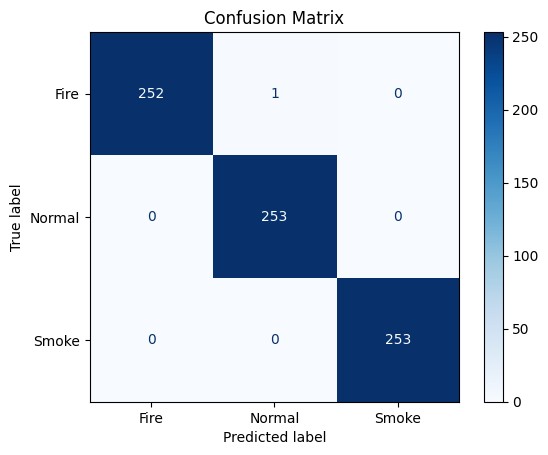

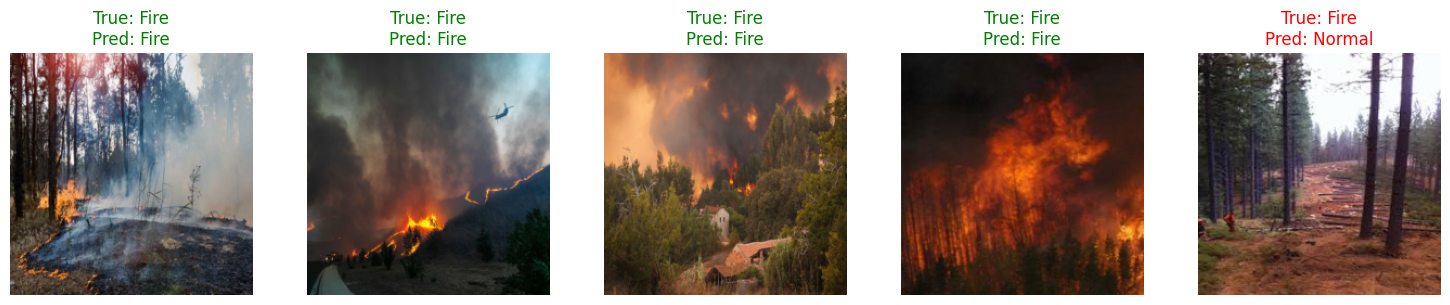

In [14]:
results = evaluate_model(model, data_module)
print(f"Final test accuracy: {results['accuracy']:.4f}")
print(f"Confusion matrix saved to: {results['confusion_matrix']}")
print(f"Sample predictions saved to: {results['sample_predictions']}")